In [1]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import string
import pytesseract
import argparse
import cv2
import os
import imutils
import re
from datetime import datetime

In [10]:
test_file_dir = "test_figures/not_clear_5.jpg" # Change this line to your testing image path

In [6]:
class tesseract_model:
    def __init__(self, image_dir, is_white_font):
        self.image_dir = image_dir
        self.image = cv2.imread(self.image_dir)
        self.tmp_file_dir = ("tmp/tmp.png")
        self.image_shape = self.image.shape
        self.is_white_font = is_white_font
    
    def pre_process(self):
        image_sharpened = self.unsharp_mask(self.image, kernel_size=(round(self.image_shape[0]/80)*2+1, round(self.image_shape[0]/80)*2+1))
        cv2.imwrite("tmp/sharpened.png", image_sharpened)
        
        image_grayscale = cv2.cvtColor(image_sharpened, cv2.COLOR_BGR2GRAY)
        if self.is_white_font:
            image_grayscale = 255-image_grayscale
        cv2.imwrite("tmp/grayscale.png", image_grayscale)
        
        image_noise_reduction = cv2.medianBlur(image_grayscale, 3)
        cv2.imwrite("tmp/noise_reduction.png", image_noise_reduction)
        
        image_downsampled = imutils.resize(image_noise_reduction, width=1000)
        image_rgb_downsampled = imutils.resize(self.image, width=1000)
        cv2.imwrite("tmp/downsampling.png", image_downsampled)
        self.image_downsampled = image_downsampled
        self.image_rgb_downsampled = image_rgb_downsampled
        
        rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (round(self.image_shape[0]/30),round(self.image_shape[1]/30)))
#         self.gray = cv2.morphologyEx(self.gray, cv2.MORPH_TOPHAT, rect_kernel)
        image_tophat = cv2.morphologyEx(image_downsampled, cv2.MORPH_BLACKHAT, rect_kernel)
        cv2.imwrite("tmp/tophat.png", image_tophat)
        
        alpha = 2.8 # Contrast control (1.0-3.0)
        beta = 0 # Brightness control (0-100)
        image_binarized = cv2.convertScaleAbs(image_tophat, alpha=alpha, beta=beta)
        image_binarized = 255-image_binarized
        cv2.imwrite("tmp/contrast_stretching.png", image_binarized)
        
        rect, self.image_preprocessed = cv2.threshold(image_binarized,60,255,cv2.THRESH_BINARY)
        cv2.imwrite("tmp/threshold_binarization.png", self.image_preprocessed)        
        return self.image_preprocessed
    
    def unsharp_mask(self, image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
        """Return a sharpened version of the image, using an unsharp mask."""
        blurred = cv2.GaussianBlur(image, kernel_size, sigma)
        sharpened = float(amount + 1) * image - float(amount) * blurred
        sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
        sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
        sharpened = sharpened.round().astype(np.uint8)
        if threshold > 0:
            low_contrast_mask = np.absolute(image - blurred) < threshold
            np.copyto(sharpened, image, where=low_contrast_mask)
        return sharpened
    
    # Houghman Transform
    def find_lines(self, image, rgb_image):
        # Apply edge detection method on the image 
        edges = cv2.Canny(image,10,20,apertureSize = 3)
        self.show(edges,title='edges')
        edges = self.dilatation(edges, 2, 0)
        self.show(edges,title='edges dilated')
        lines = cv2.HoughLines(edges,1,np.pi/180, 100)
        draw_image = np.copy(image)
        for r,theta in lines[0]:
            a = np.cos(theta) 
            b = np.sin(theta) 
            x0 = a*r 
            y0 = b*r 
            x1 = int(x0 + 1000*(-b)) 
            y1 = int(y0 + 1000*(a)) 
            x2 = int(x0 - 2000*(-b)) 
            y2 = int(y0 - 2000*(a)) 
            cv2.line(draw_image,(x1,y1), (x2,y2), (0,0,255),50) 
        self.show(draw_image, "image with lines")
        return draw_image
    
    def to_string(self, file_dir):
        custom_oem_psm_config = '-c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789% ."'
        self.text = pytesseract.image_to_string(Image.open(file_dir), config=custom_oem_psm_config)
        return self.text
        
    def to_boxes(self, file_dir):
        custom_oem_psm_config = '-c tessedit_char_whitelist="ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789% ."'
        self.boxes = pytesseract.image_to_boxes(Image.open(file_dir), config=custom_oem_psm_config)
        return self.boxes
 
    def extract_lines(self, image):
        horizontal = np.copy(image)
        vertical = np.copy(image)
        cols = horizontal.shape[1]
        horizontalz_size = cols // 30
        horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontalz_size, 1))
        horizontal = cv2.erode(horizontal, horizontalStructure)
        horizontal = cv2.dilate(horizontal, horizontalStructure)
        
        rows = vertical.shape[0]
        verticalsize = rows // 30
        verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))
        vertical = cv2.erode(vertical, verticalStructure)
        vertical = cv2.dilate(vertical, verticalStructure)
        
        return horizontal, vertical

    def erosion(self, src, erosion_size=3, val_type=0):
        if val_type == 0:
            erosion_type = cv2.MORPH_RECT
        elif val_type == 1:
            erosion_type = cv2.MORPH_CROSS
        elif val_type == 2:
            erosion_type = cv2.MORPH_ELLIPSE
        element = cv2.getStructuringElement(erosion_type, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size))
        return cv2.erode(src, element)
        
    def dilatation(self, src, dilatation_size=3, val_type=0):
        if val_type == 0:
            dilatation_type = cv2.MORPH_RECT
        elif val_type == 1:
            dilatation_type = cv2.MORPH_CROSS
        elif val_type == 2:
            dilatation_type = cv2.MORPH_ELLIPSE
        element = cv2.getStructuringElement(dilatation_type, (2*dilatation_size + 1, 2*dilatation_size+1), (dilatation_size, dilatation_size))
        return cv2.dilate(src, element)

    def show(self, image, title=''):
        plt.figure()
        plt.title(title)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.show()
        

In [7]:
class nutrition_label:
    def __init__(self):
        self.nutrition_label = ["totalfat", "saturatedfat", "transfat",
            "cholesterol", "sodium", "totalcarbohydrate", "dietaryfiber",
            "totalsugers", "protein", "vitamind", "calories", "calcium",
            "iron", "potassium", "totalsugars", "totalcarb.", "potas.",
            "dietaryfiber"]
        
    def extract_valid_values(self, text):
        lines = text.split("\n")
        lines = list(filter(lambda line: not line == ' ' and not line == '', lines))
        res = dict()
        for line in lines:
            word_list = line.split(" ")
            word_list = list(filter(lambda word: not word == ' ' and not word == '', word_list))
            label_string_tmp = ""
            for i in range(len(word_list)):
                match_flag = False
                word = word_list[i]
                if not str.isnumeric(word[0]):
                    label_string_tmp += word.lower()
                else: break
                for label in self.nutrition_label:
                    if label in label_string_tmp:
                        if not label in res:
                            res[label] = word_list[i+1:]
                            match_flag = True
                            break
                if match_flag: break
        return res
    
    def post_processing(self, res_dict):
        pattern_list = ["(\d*)meg$", "(\d*)mg$", "(\d*)g$", '(\d*)%$', '(\d*)$', 'less', 'than']
        for res in res_dict:
            for i in range(len(res_dict[res])):
                feature = res_dict[res][i]
                if not re.match("^(O).*$", feature) == None:
                    res_dict[res][i] = "0"+feature[1:]
                if not re.match("^(\d+)9$", feature) == None:
                    res_dict[res][i] = feature[0:len(feature)-1]+"g"
        for res in res_dict:
            for feature in res_dict[res]:
                match = False
                for pattern in pattern_list:
                    if not re.match(pattern, feature) == None:
#                         print("{}: {}".format(feature, pattern))
                        match = True
                if not match:
                    res_dict[res].remove(feature)
        return res_dict
                    

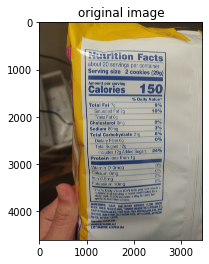

=== Image shape: (4608, 3456, 3) ===


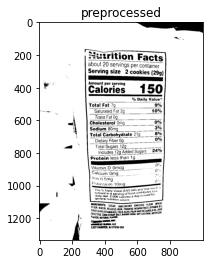

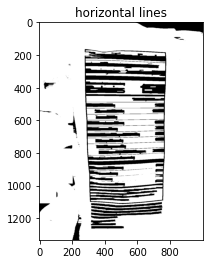

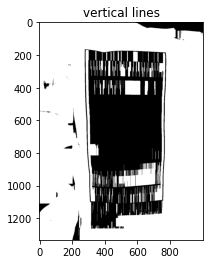

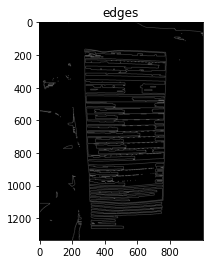

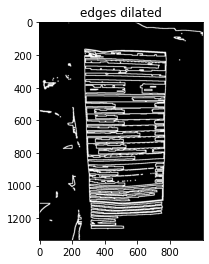

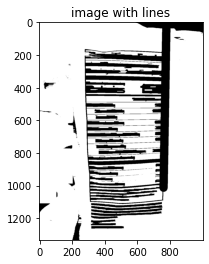

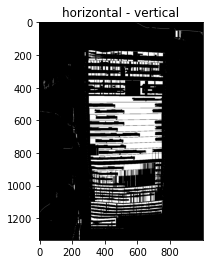

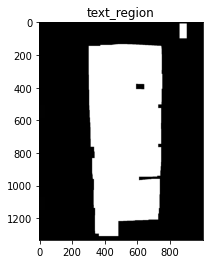

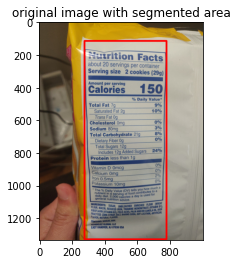

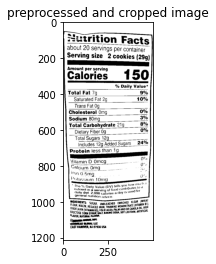

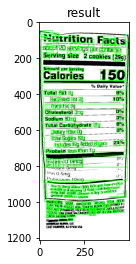


=== text data ===
ad.
Swe 8
aawe

   

trition Facts

an NE AUS
about 20 Servings per container
Serving size 2 cookies 29g

Amount per serving

Calories 150

Total Fat 7g 9%

Saturated Fat 2g 10%

 

TransFat0g
Cholesterol Omg 0%
Sodium 80mg 3%
Total Carbohydrate 21g 8%

Dietary Fiber 0g 0%

Total Sugars 129
Includes 12g Added Sugars 24%

Protein less than 1g

Vitamin DOmeg

nat

The % Daily Value DYD tells you Nowe ae
Autdent in 2 serving of food contibutes
dally diel. 2.000 calories a day 5 used
general nuttition advice

      

     

FOMeCHENTS SUGAR ED ENRICHED. FLOUR MHEH
FLOUR MACE REDUCED om. THUAMINE OHOATRATE rth

RIBOFLAVIN PALM ANDIOA CAN
FRUCTOSE Ca econ So0K. SOY LECITHM. ARTI
FLAVOR. WATURAL FLAVOR.

a BK.


=== structured data ===
calories:['150']
totalfat:['7g', '9%']
saturatedfat:['2g', '10%']
transfat:[]
cholesterol:['0mg', '0%']
sodium:['80mg', '3%']
totalcarbohydrate:['21g', '8%']
dietaryfiber:['0g', '0%']
totalsugars:['12g']
protein:['less', 'than', '1g']
vitamin

In [13]:
start_time=datetime.now()
testModel = tesseract_model(test_file_dir, False)
testModel.show(testModel.image, "original image")
print("=== Image shape: {} ===".format(testModel.image.shape))
image_preprocessed = testModel.pre_process()
testModel.show(image_preprocessed, title='preprocessed')
horizontal, vertical = testModel.extract_lines(testModel.image_preprocessed)
testModel.show(horizontal, 'horizontal lines')
testModel.show(vertical, 'vertical lines')
cv2.imwrite("tmp/horizontal.png", horizontal)
cv2.imwrite("tmp/vertical.png", vertical)
testModel.find_lines(horizontal, testModel.image)

text_region = np.abs(horizontal - vertical)
cv2.imwrite("tmp/h_v_diff.png", text_region)
testModel.show(text_region, 'horizontal - vertical')

horizontalStructure_short = cv2.getStructuringElement(cv2.MORPH_RECT, (text_region.shape[0]//30, 1))
horizontalStructure_long = cv2.getStructuringElement(cv2.MORPH_RECT, (text_region.shape[0]//10, 1))
text_region = cv2.dilate(text_region, horizontalStructure_short)
text_region = cv2.erode(text_region, horizontalStructure_long)
text_region = cv2.dilate(text_region, horizontalStructure_short)
verticalStructure_short = cv2.getStructuringElement(cv2.MORPH_RECT, (1, text_region.shape[1]//100))
verticalStructure_long = cv2.getStructuringElement(cv2.MORPH_RECT, (1, text_region.shape[1]//10))
text_region = cv2.dilate(text_region, verticalStructure_long)
text_region = cv2.erode(text_region, verticalStructure_short)
# text_region = testModel.erosion(text_region, erosion_size=10, val_type=1)
testModel.show(text_region, 'text_region')
cv2.imwrite("tmp/text_region.png", text_region)

ret, thresh = cv2.threshold(text_region,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# You need to choose 4 or 8 for connectivity type
connectivity = 4  
# Perform the operation
output = cv2.connectedComponentsWithStats(thresh, connectivity, cv2.CV_32S)
# Get the results
# The first cell is the number of labels
num_labels = output[0]
# The second cell is the label matrix
labels = output[1]
# The third cell is the stat matrix
stats = output[2]
# The fourth cell is the centroid matrix
centroids = output[3]

sizes = stats[1:, -1]
test_image = np.copy(testModel.image_rgb_downsampled)
test_image_gray = np.copy(testModel.image_preprocessed)
test_image_gray = cv2.cvtColor(test_image_gray, cv2.COLOR_GRAY2BGR)

img = np.zeros((labels.shape))
min_size = sizes[np.argsort(-sizes)][0] * 0.3
for i in range(sizes.shape[0]):
    if sizes[i] >= min_size:
        img[labels == i + 1] = 255

bright_areas_index = np.where(img == 255)
x1 = np.amin(bright_areas_index[1]) - test_image.shape[0] // 50
x2 = np.amax(bright_areas_index[1]) + test_image.shape[0] // 50
y1 = np.amin(bright_areas_index[0]) - test_image.shape[1] // 50
y2 = np.amax(bright_areas_index[0]) + test_image.shape[1] // 50
if x1 < 0: x1 = 0
if x2 >= test_image.shape[1]: x2 = test_image.shape[1]-1
if y1 < 0: y1 = 0
if y2 >= test_image.shape[0]: y2 = test_image.shape[0]-1
test_image = cv2.rectangle(test_image, (x1,y1), (x2,y2), (0, 0, 255) , 10) 
testModel.show(test_image, "original image with segmented area")
test_image_gray = cv2.rectangle(test_image_gray, (x1,y1), (x2,y2), (0, 0, 255) , 10)
cv2.imwrite("tmp/segmentation.png", test_image)
cv2.imwrite("tmp/segmentation_gray.png", test_image_gray)

processed_image = np.copy(testModel.image_preprocessed)
processed_image = processed_image[y1:y2, x1:x2]
# print("{},{},{},{}".format(x1, x2, y1, y2))
cv2.imwrite("tmp/preprossed_segmented.png", processed_image)
testModel.show(processed_image, 'preprocessed and cropped image')

boxes = testModel.to_boxes("tmp/preprossed_segmented.png")
processed_image_copy = cv2.cvtColor(np.copy(processed_image), cv2.COLOR_GRAY2BGR)
h = processed_image_copy.shape[0]
rect_list = boxes.split("\n")
for rect in rect_list:
    line = rect.split(" ")
    processed_image_copy = cv2.rectangle(processed_image_copy, (int(line[1]), h - int(line[2])), (int(line[3]), h - int(line[4])), (0, 255, 0) , 2)
testModel.show(processed_image_copy, 'result')

texts = testModel.to_string("tmp/preprossed_segmented.png")
print("\n=== text data ===")
print(texts)

label_model = nutrition_label()
res_dict = label_model.extract_valid_values(texts)

res_dict = label_model.post_processing(res_dict)
print("\n\n=== structured data ===")
for res in res_dict:
    print("{}:{}".format(res, res_dict[res]))
    
print("\n=== run time ===\n{} seconds".format(datetime.now()-start_time))